# Analysis Overview

This notebook includes a general overview of the dataset by (1) preparing your workspace to use the dataset in the COCO format, (2) visualizing a few images from one of the datasets for information purposes, and (3) conducting an analysis on modifications made to the Faster R-CNN model.  The dataset used is the SARscope dataset found at the below link.  The objective of this project is to determine whether proposed image processing methods would increase the performance of different models on Synthetic Aperture Radar data of maritime vessels.

Dataset: https://www.kaggle.com/datasets/kailaspsudheer/sarscope-unveiling-the-maritime-landscape

## Section 1 - Workspace Preparation

To ensure that the user can run this notebook without issue, please do the following:

1. Ensure your Python installtion is 3.8.10 or higher.
2. You are using the pip3 package manager.
3. Run the below installation steps. These are all the packages used in this notebook.

In [1]:
# %pip3 install torch
# %pip3 install torchvision
# %pip3 install torchmetrics
# %pip3 install kagglehub
# %pip3 install json
# %pip3 install matplotlib
# %pip3 install cv2
# %pip install pycocotools
# %pip install utils

In [ ]:
# Utility Imports
import os, sys
import pathlib

# Data Handling Imports
from SeaSarFRCNN import SeaSarFRCNN
from ModelWorker import ModelWorkerFRCNN
from WorkspaceManager import WorkspaceManager

# Data & Model Imports
import torchvision
import torch

project_path = pathlib.Path.cwd().parent.resolve()
print(f"Project path: {project_path}")

Project path: /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR


/home/jag1799/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Section 2 - Dataset Loading

### Section 2.1: Note on Kagglehub

Kagglehub does not natively support downloading to specific directories on the user's file system.  It instead downloads it to a cache folder, which may vary between users.  Thus, the below script moves all downloads will move the dataset folder to the included */data* folder in this repo.

If you have an error, this is likely due to the `shutil.move()` command failing because it sees the dataset still cached.  To counteract this, `cd` into the cache directory that is printed in the output and delete the entire data folder.  Then run this block again.  See Section 2.2 and the below code block comments for additional information.

### Section 2.2: Deleting the Cache

To re-download the dataset, you need to remove both the formatted folder in this repo's data directory (the *kaggle* folder) and the *kailaspsudheer* folder in the cache.

I recommend you run the *WorkspaceManager* setup block below with *clear_cache* off first, then manually delete it if you need to.  After you know where your cache is and confirm it's deleting the right directory, you can turn it on.

In [3]:
workspace_builder = WorkspaceManager()
workspace_builder.run_setup()

if not os.path.exists(workspace_builder._data_path):
    raise FileNotFoundError(f"Not able to find data directory at path: {workspace_builder._data_path}")
else:
    print(f"Using data path: {workspace_builder._data_path}")

Project path: /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR
Found existing data path at /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/data/kaggle
Using data path: /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/data/kaggle/SARscope


## Section 3 - Data Visualization

Below, we visualize a few randomly selected images throughout the validation dataset as examples of the different types of images the models will encounter and to ensure the annotations are working as expected.  All targets have the same category Id and category name: (1, "ship").

In [4]:
# Validation Path retrieval
tester_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_annotations = os.path.join(workspace_builder._data_path, "annotations", "train_annotations.coco.json")
train_images = os.path.join(workspace_builder._data_path, "train")

train_data = SeaSarFRCNN(train_images, train_annotations, tester_transforms)

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!


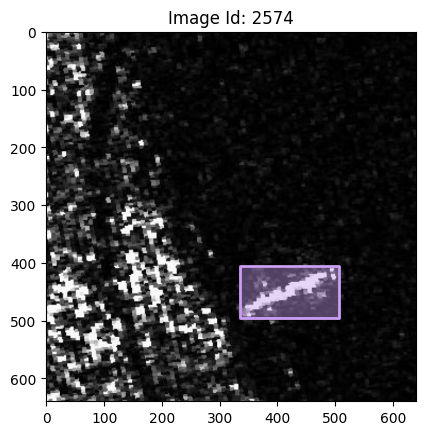

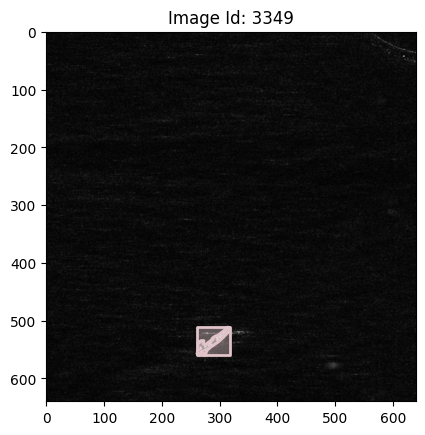

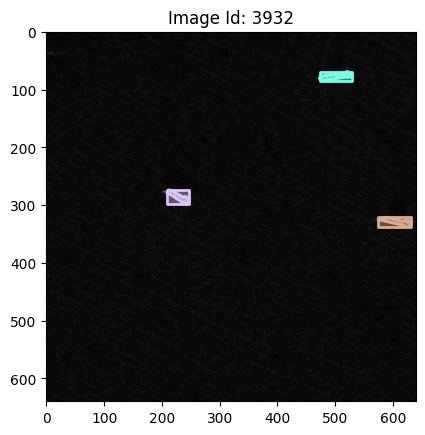

In [5]:
# Display 3 randomly selected images throughout the validation dataset with their annotations.
for i in range(3):
    train_data.show_random_image()

## Section 4 - Faster R-CNN

This section begins the analysis of different layer additions and modifications to the Faster R-CNN model.  Each section contains the following sub-sections for reference:

1. Data Preparation
2. Model Construction
3. Training
4. Testing & Analysis

### Section 4.1 - Baseline FRCNN

This section is to establish the baseline performance of an unmodified FRCNN model on our dataset.

#### Section 4.1.1 - Data Preparation

In [6]:
# Set up train dataloader
train_data = torchvision.datasets.wrap_dataset_for_transforms_v2(train_data, target_keys=("boxes", "labels"))
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False, collate_fn=train_data._packager)

In [7]:
validation_annotations = os.path.join(workspace_builder._data_path, "annotations", "valid_annotations.coco.json")
validation_images = os.path.join(workspace_builder._data_path, "valid")
validation_data = SeaSarFRCNN(validation_images, validation_annotations)
validation_data = torchvision.datasets.wrap_dataset_for_transforms_v2(validation_data, target_keys=("boxes", "labels"))
validation_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=1, shuffle=False, collate_fn=validation_data._packager)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


#### Section 4.1.2 - Model Setup

In [8]:
# Build the baseline model
frcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn()
input_features = frcnn.roi_heads.box_predictor.cls_score.in_features
frcnn.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(input_features, 2)

# Build the loss function and optimizer
optimizer = torch.optim.Adam(frcnn.parameters(), lr=0.001)

#### Section 4.1.3 - Baseline Training & Validation

In [9]:
# Do training and validation
worker = ModelWorkerFRCNN(train_dataloader=train_dataloader, validation_dataloader=validation_dataloader, optimizer=optimizer, frcnn=frcnn, quiet=False)
worker.model_train_val(1)

Pytorch found device: cuda
Beginning Epoch
Starting Training in Epoch 0


KeyboardInterrupt: 